In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import datetime 

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split  # Correct import

import sqlite3
import sys
import time
import tqdm
from tqdm.auto import tqdm
import pickle
import joblib
import os

if os.path.exists('/workspace/data'):
    # Load the dictionary of DataFrames from the pickle
    data_path = '/workspace/data/'
else:
    data_path = '../data/'

In [263]:
players_df = pd.read_pickle(data_path + '/labelled_data/players_df.pkl')
players_df.head()

,game,player_id,tag,all_tags,prefixes,social,country,state,region,c_country,c_state,c_region,placings,characters,alias
0,melee,Rishi,Rishi,[Rishi],[],{'twitter': []},,,,None,None,None,[{'key': 'mdva-invitational-2017-(challonge-mi...,,None
1,melee,15634,lloD,"[lloD, VGz | lloD, Llod]",[],{'twitter': ['lloD74']},United States,VA,,US,CA,Laurel,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/peach': 1089, 'melee/falco': 1, 'melee...",None
2,melee,6126,Zain,"[Zain, DontTestMe]",[PG],{'twitter': ['PG_Zain']},United States,VA,,US,CA,Los Angeles,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/marth': 1065, 'melee/pichu': 1, 'melee...",DontTestMe
3,melee,Chu,Chu,[Chu],[],{'twitter': []},,,,None,None,None,[{'key': 'mdva-invitational-2017-(challonge-mi...,,None
4,melee,5620,Junebug,"[Junebug, LS | VGz Junebug]",[],{'twitter': ['arJunebug']},United States,VA,,US,VA,Richmond,[{'key': 'mdva-invitational-2017-(challonge-mi...,"{'melee/sheik': 46, 'melee/falco': 4, 'melee/g...",None


In [ ]:
sets_df = pd.read_pickle(data_path + '/labelled_data/sets_df_2.pkl')
print(f"{sets_df[sets_df['game_data'].apply(lambda x: len(x) > 0)].shape[0] / sets_df.shape[0]:0.01%} percent of sets have some game data")
print(sets_df.shape)
sets_df.head(3)

In [ ]:
tournament_info_df = pd.read_pickle(data_path + '/labelled_data/tournament_info_df.pkl')
print(tournament_info_df.shape)
tournament_info_df.head(3)

(39675, 37)


,game,key,cleaned_name,source,tournament_name,tournament_event,season,rank,start,end,...,WSF_B_p2,LN_A_p1_non_top_8_sets,LN_A_p2_non_top_8_sets,LN_B_p1_non_top_8_sets,LN_B_p2_non_top_8_sets,WSF_A_p1_non_top_8_sets,WSF_A_p2_non_top_8_sets,WSF_B_p1_non_top_8_sets,WSF_B_p2_non_top_8_sets,major
0,melee,mdva-invitational-2017-(challonge-mirror),MDVA Invitational 2017 (Challonge Mirror),challonge,https://challonge.com/mdva_invitational_2017,,17,,2017-11-26 08:05:11,2017-11-26 08:48:09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,melee,s@sh7,S@SH7,challonge,https://challonge.com/sash7,,17,,2017-06-13 10:27:01,2017-06-13 10:27:01,...,Ginger,"[(32, True), (62, True), (77, False), (164, Tr...","[(39, True), (65, True), (78, False), (165, Tr...","[(47, True), (69, True), (80, False), (159, Tr...","[(40, True), (66, True), (79, True), (85, Fals...","[(28, True), (60, True), (76, True), (84, True)]","[(36, True), (64, True), (78, True), (85, True)]","[(44, True), (68, True), (80, True), (86, True)]","[(52, True), (72, True), (82, True), (87, True)]",NaN
2,melee,slippi-champions-league-week-1__melee-singles,Slippi Champions League Week 1,pgstats,slippi-champions-league-week-1,melee-singles,20,,2020-10-11 14:00:00,2020-10-11 14:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [ ]:
overall_players_ranking_new_weekly_df = pd.read_pickle(data_path + 'overall_players_ranking_new_weekly.pkl')
overall_players_ranking_new_weekly_df.sample(3)

,1617201,1497667,2653190,3657740,41449,6039,3621289,3682293,3332271,2034855,...,1911774,4106746,Black hayato,The boy,138692,3293641,1701726,2408932,SmyD,15495
2020-12-24,1305.337441,1500.0,1500.0,1500.0,1147.194923,1362.829389,1500.0,1500.0,1500.0,1500.0,...,1500.000000,1500.0,1337.689105,1400.124736,1397.772865,1500.0,1500.0,1500.000000,1559.078031,1482.878104
2022-12-01,1305.337441,1500.0,1500.0,1500.0,1506.618655,1362.829389,1500.0,1500.0,1500.0,1500.0,...,1352.175467,1500.0,1337.689105,1400.124736,1397.772865,1500.0,1500.0,1514.677506,1559.078031,1482.878104
2018-04-12,1500.000000,1500.0,1500.0,1500.0,1147.194923,1362.829389,1500.0,1500.0,1500.0,1500.0,...,1500.000000,1500.0,1337.689105,1400.124736,1397.772865,1500.0,1500.0,1500.000000,1559.078031,1482.878104


In [ ]:
overall_players_rds_new_weekly_df = pd.read_pickle(data_path + 'overall_players_rds_new_weekly.pkl')
overall_players_rds_new_weekly_df.sample(3)

,1617201,1497667,2653190,3657740,41449,6039,3621289,3682293,3332271,2034855,...,1911774,4106746,Black hayato,The boy,138692,3293641,1701726,2408932,SmyD,15495
2024-04-11,280.662016,274.305922,198.558973,252.583726,45.051790,305.198096,234.781374,176.437924,245.107489,180.374411,...,100.055192,350.0,350.000000,318.260575,297.866687,127.969766,244.557607,224.292172,282.261385,254.804539
2023-12-28,277.743600,271.316329,194.411630,249.334261,49.774455,302.516730,231.285219,171.724652,241.760308,175.799395,...,91.576214,350.0,350.000000,315.690279,295.118860,121.436121,241.200093,220.630489,279.360447,251.587329
2022-01-06,256.809606,350.000000,350.000000,350.000000,67.904410,283.420350,350.000000,350.000000,350.000000,350.000000,...,95.840371,350.0,347.702312,297.441630,275.511247,350.000000,350.000000,193.625600,258.563107,228.274452


In [ ]:
char_vs_char_player_rankings_weekly_alt2_df = pd.read_pickle(data_path + 'char_vs_char_player_rankings_weekly_alt2.pkl')
char_vs_char_player_rankings_weekly_alt2_df.sample(3)

,3688504/sheik/roy,3688504/sheik/samus,3688504/sheik/sheik,3689802/sheik/marth,3689821/falco/falco,3689821/falco/fox,3689821/falco/jigglypuff,3689821/falco/kirby,3689821/falco/marth,3689821/falco/mewtwo,...,368847/fox/pikachu,368847/fox/samus,368847/fox/sheik,3688504/sheik/captainfalcon,3688504/sheik/falco,3688504/sheik/fox,3688504/sheik/jigglypuff,3688504/sheik/luigi,3688504/sheik/marth,3688504/sheik/peach
2022-12-15,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2018-04-05,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0
2020-07-16,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,...,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0,1500.0


In [ ]:
char_vs_char_player_rankings_weekly_alt2_rds_df = pd.read_pickle(data_path + 'char_vs_char_player_rankings_weekly_alt2_rds.pkl')
char_vs_char_player_rankings_weekly_alt2_rds_df.sample(3)

,1960158/fox/mewtwo,1960158/fox/roy,1960158/jigglypuff/falco,1960158/jigglypuff/fox,1960158/jigglypuff/iceclimbers,1960158/jigglypuff/jigglypuff,1960158/jigglypuff/link,1960158/jigglypuff/luigi,1960158/jigglypuff/marth,1960158/jigglypuff/sheik,...,999886/luigi/falco,999886/marth/captainfalcon,999886/sheik/falco,999888/sheik/captainfalcon,999888/sheik/falco,999888/sheik/fox,999888/sheik/jigglypuff,999888/sheik/marth,999888/sheik/mrgameandwatch,999888/sheik/samus
2016-12-22,350.0,350.0,350.0,350.000000,350.0,350.0,350.0,350.0,350.0,350.0,...,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0
2020-10-29,350.0,350.0,350.0,239.371735,350.0,350.0,350.0,350.0,350.0,350.0,...,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0
2019-06-06,350.0,350.0,350.0,350.000000,350.0,350.0,350.0,350.0,350.0,350.0,...,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0,350.0


In [ ]:
sets_without_character_changes_df=pd.read_pickle(data_path + '/labelled_data/sets_without_character_changes_df.pkl')
sets_without_character_changes_df.head(3)

,key,game,tournament_key,tournament_start_date,winner_id,loser_id,p1_id,p2_id,p1_score,p2_score,...,top_8,top_8_location_names,valid_top_8_bracket,top_8_bracket_location_names,major,ranking_date_index,length_gamedata,p1_characters,p2_characters,matchup
19575,,melee,evo-2018__evo-2018-1,2018-08-03 15:00:00,6126,1009,1009,6126,0,2,...,False,,False,,True,187,2,fox,marth,fox/marth
19582,,melee,evo-2018__evo-2018-1,2018-08-03 15:00:00,1004,6126,1004,6126,2,0,...,False,,False,,True,187,2,jigglypuff,marth,jigglypuff/marth
19626,,melee,evo-2018__evo-2018-1,2018-08-03 15:00:00,1028,1055,1028,1055,2,0,...,True,LN,True,LN_B,True,187,2,captainfalcon,sheik,captainfalcon/sheik


In [ ]:
path = data_path + 'predict_matchup_dataset/'
overall_elos = pd.read_pickle(path + 'overall_elos.pkl')
matchup_sets_df = pd.read_pickle(path + 'matchup_sets_df.pkl')
p1_alt_2 = pd.read_pickle(path + 'p1_alt_2.pkl')
p2_alt_2 = pd.read_pickle(path + 'p2_alt_2.pkl')
p1_alt_2_rds = pd.read_pickle(path + 'p1_alt_2_rds.pkl')
p2_alt_2_rds = pd.read_pickle(path + 'p2_alt_2_rds.pkl')

In [ ]:
print(overall_elos.shape)
print(matchup_sets_df.shape)
print(p1_alt_2.shape)
print(p2_alt_2.shape)
print(p1_alt_2_rds.shape)
print(p2_alt_2_rds.shape)

(437200, 4)
(437200, 27)
(437200, 678)
(437200, 678)
(437200, 678)
(437200, 678)


In [ ]:
matchup_sets_df['p1_characters'].value_counts().index.values

array(['fox', 'falco', 'marth', 'sheik', 'captainfalcon', 'jigglypuff',
       'peach', 'luigi', 'samus', 'ganondorf', 'iceclimbers', 'drmario',
       'yoshi', 'pikachu', 'link', 'mario', 'mrgameandwatch',
       'donkeykong', 'roy', 'zelda', 'kirby', 'ness', 'younglink',
       'pichu', 'bowser', 'mewtwo'], dtype=object)

Choose a subset of matchup_sets_df to train the model on.

In [ ]:
num_pop = 7
characters = matchup_sets_df['p1_characters'].value_counts().head(num_pop).index.values
matchups = [char_1 + '/' + char_2 for char_1 in characters for char_2 in characters]

training_sets_df = matchup_sets_df[matchup_sets_df['p1_characters'].isin(characters) & matchup_sets_df['p2_characters'].isin(characters)].copy()
# training_sets_df = matchup_sets_df
# training_sets_df.shape[0]
print(characters)
print(training_sets_df['matchup'].value_counts().to_string())
training_sets_df.shape[0]
# print(characters)

['fox' 'falco' 'marth' 'sheik' 'captainfalcon']
matchup
fox/fox                        17883
fox/falco                      17509
falco/fox                      15748
falco/falco                    14002
fox/marth                      12006
marth/fox                      10477
falco/marth                     9906
sheik/fox                       9801
marth/falco                     9647
fox/sheik                       9647
sheik/falco                     8162
fox/captainfalcon               8085
captainfalcon/fox               7593
falco/sheik                     7522
captainfalcon/falco             7160
falco/captainfalcon             6818
sheik/marth                     6115
marth/marth                     6078
marth/sheik                     5465
captainfalcon/marth             5011
marth/captainfalcon             4486
sheik/captainfalcon             3992
captainfalcon/sheik             3845
sheik/sheik                     3749
captainfalcon/captainfalcon     3381


214088

Filter the training data.

In [ ]:
def choose_subset(training_df, df):
    index_list = list(training_df.index)
    return df.loc[index_list]

training_p1_alt_2 = choose_subset(training_sets_df, p1_alt_2)[matchups]
training_p2_alt_2 = choose_subset(training_sets_df, p2_alt_2)[matchups]
training_p1_alt_2_rds = choose_subset(training_sets_df, p1_alt_2_rds)[matchups]
training_p2_alt_2_rds = choose_subset(training_sets_df, p2_alt_2_rds)[matchups]
print(training_p2_alt_2_rds.columns)

# # Remove the first two columns from each DataFrame
# training_p1_alt_2 = training_p1_alt_2.iloc[:, 2:]
# training_p2_alt_2 = training_p2_alt_2.iloc[:, 2:]
# training_p1_alt_2_rds = training_p1_alt_2_rds.iloc[:, 2:]
# training_p2_alt_2_rds = training_p2_alt_2_rds.iloc[:, 2:]

# Add prefixes to column names for each DataFrame
training_p1_alt_2 = training_p1_alt_2.add_prefix('p1_rating/')
training_p2_alt_2 = training_p2_alt_2.add_prefix('p2_rating/')
training_p1_alt_2_rds = training_p1_alt_2_rds.add_prefix('p1_rds/')
training_p2_alt_2_rds = training_p2_alt_2_rds.add_prefix('p2_rds/')

X = pd.concat((training_p1_alt_2, training_p2_alt_2, training_p1_alt_2_rds, training_p2_alt_2_rds), axis=1)

y = training_sets_df['matchup']

print(training_p2_alt_2_rds.columns)

Index(['fox/fox', 'fox/falco', 'fox/marth', 'fox/sheik', 'fox/captainfalcon',
       'falco/fox', 'falco/falco', 'falco/marth', 'falco/sheik',
       'falco/captainfalcon', 'marth/fox', 'marth/falco', 'marth/marth',
       'marth/sheik', 'marth/captainfalcon', 'sheik/fox', 'sheik/falco',
       'sheik/marth', 'sheik/sheik', 'sheik/captainfalcon',
       'captainfalcon/fox', 'captainfalcon/falco', 'captainfalcon/marth',
       'captainfalcon/sheik', 'captainfalcon/captainfalcon'],
      dtype='object')
Index(['p2_rds/fox/fox', 'p2_rds/fox/falco', 'p2_rds/fox/marth',
       'p2_rds/fox/sheik', 'p2_rds/fox/captainfalcon', 'p2_rds/falco/fox',
       'p2_rds/falco/falco', 'p2_rds/falco/marth', 'p2_rds/falco/sheik',
       'p2_rds/falco/captainfalcon', 'p2_rds/marth/fox', 'p2_rds/marth/falco',
       'p2_rds/marth/marth', 'p2_rds/marth/sheik',
       'p2_rds/marth/captainfalcon', 'p2_rds/sheik/fox', 'p2_rds/sheik/falco',
       'p2_rds/sheik/marth', 'p2_rds/sheik/sheik',
       'p2_rds/sheik

In [ ]:

# find the n most popular characters
# num_pop = 6
# characters = training_sets_df['p1_characters'].value_counts().head(num_pop).index.values
# print(characters)
# Each player must have at least one rds score against each of the n most popular characters below the threshold
min_rds = 100


# Get unique characters by parsing column names
characters = set(col.split('/')[1] for col in training_p1_alt_2_rds.columns)

# Function to check if a player has at least one rds below min_rds for each character
def player_has_rds_below_threshold(df, player_prefix, min_rds):
    condition = pd.Series([True] * len(df), index=df.index)  # Ensure same index as df
    for opp_char in characters:
        # Select all columns related to the character for the specific player
        char_cols = [f"{player_prefix}/{char}/{opp_char}" for char in characters]
        
        # Check if there's at least one column value below the threshold for each character
        char_condition = df[char_cols].min(axis=1) < min_rds
        condition &= char_condition
    return condition

# Apply the function to get conditions for both players
p1_condition = player_has_rds_below_threshold(training_p1_alt_2_rds, 'p1_rds', min_rds)
p2_condition = player_has_rds_below_threshold(training_p2_alt_2_rds, 'p2_rds', min_rds)

# Combine the conditions
combined_condition = p1_condition & p2_condition

# Filter the training data and labels where both conditions are met
filtered_X = X[combined_condition]
filtered_y = y[combined_condition]

# Verify alignment of filtered_X and filtered_y
print()
print(f"Original Data Size: {X.shape[0]}")
print(f"Filtered Data Size: {filtered_X.shape[0]}")
# print(f"Original Label Size: {y.shape[0]}")
# print(f"Filtered Label Size: {filtered_y.shape[0]}")
# print(f"Filtered labels: {pd.Series(label_encoder.inverse_transform(filtered_y)).value_counts()}")

# Display a small sample of the filtered data and labels to verify
# print(filtered_X.head())
# print(filtered_y[:5])
print(filtered_y.value_counts().to_string())


Original Data Size: 214088
Filtered Data Size: 24970
matchup
fox/fox                        2419
falco/fox                      1819
fox/falco                      1762
sheik/fox                      1508
fox/marth                      1434
fox/sheik                      1270
marth/fox                      1224
captainfalcon/fox              1163
falco/falco                    1118
fox/captainfalcon              1116
sheik/falco                     930
falco/marth                     890
marth/falco                     845
falco/sheik                     828
captainfalcon/falco             807
sheik/marth                     803
falco/captainfalcon             686
marth/marth                     638
sheik/captainfalcon             607
captainfalcon/sheik             592
marth/sheik                     570
captainfalcon/marth             568
sheik/sheik                     565
marth/captainfalcon             420
captainfalcon/captainfalcon     388


In [ ]:
# # Calculate the counts of each matchup in `filtered_y`
# matchup_counts = pd.Series(filtered_y).value_counts()

# # Filter for matchups with at least 50 samples
# valid_matchups = matchup_counts[matchup_counts >= 40].index

# # Apply the filter to `filtered_X` and `filtered_y`
# filtered_X = filtered_X[filtered_y.isin(valid_matchups)]
# filtered_y = filtered_y[filtered_y.isin(valid_matchups)]

# # Display the new sizes
# print(f"Filtered Data Size (after discarding low-sample matchups): {filtered_X.shape[0]}")
# print(f"Filtered Label Size (after discarding low-sample matchups): {filtered_y.shape[0]}")

# # Verify that all remaining matchups have at least 50 samples
# print(pd.Series(filtered_y).value_counts())


Train a model

In [ ]:
X = filtered_X
# Encode the labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_y)

# y = filtered_y

# Perform train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42, stratify=y)

classifier = XGBClassifier(eval_metric='mlogloss', random_state=42, n_estimators=100, tree_method='hist', max_depth=7)

# Train the classifier on the training data
classifier.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

Evaluate the model.

In [ ]:
from collections import Counter
from sklearn.metrics import log_loss

# Make predictions on the test set
y_pred = classifier.predict(X_test)
y_pred_proba = classifier.predict_proba(X_test)  # Get probabilities for log_loss

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
cohen_kappa = cohen_kappa_score(y_test, y_pred)
# log_loss_score = log_loss(y_test, y_pred_proba)  # Use y_pred_proba here

print(f"Test Accuracy: {accuracy:.2f}")
print(f"Cohen Kappa Score: {cohen_kappa:.2f}")
# print(f"Log Loss Score: {log_loss_score:.2f}")

# Calculate the number of samples (support) for each class in y_test
class_counts = Counter(y_test)

# Sort classes by the number of samples in descending order
sorted_classes = [cls for cls, _ in class_counts.most_common()]

# Get the target names in the same order as sorted_classes
sorted_target_names = label_encoder.inverse_transform(sorted_classes)

# Generate the classification report with ordered classes
print("Classification Report (Ordered by Sample Count):")
print(classification_report(y_test, y_pred, labels=sorted_classes, target_names=sorted_target_names))

Test Accuracy: 0.91
Cohen Kappa Score: 0.90
Classification Report (Ordered by Sample Count):
                             precision    recall  f1-score   support

                    fox/fox       0.86      0.91      0.89       349
                  falco/fox       0.87      0.89      0.88       265
                  fox/falco       0.95      0.86      0.90       246
                  sheik/fox       0.92      0.92      0.92       234
                  fox/marth       0.90      0.90      0.90       199
                  fox/sheik       0.91      0.90      0.91       191
                  marth/fox       0.91      0.89      0.90       169
          captainfalcon/fox       0.94      0.91      0.92       168
          fox/captainfalcon       0.90      0.90      0.90       157
                falco/falco       0.87      0.86      0.87       157
             fox/jigglypuff       0.88      0.88      0.88       154
             jigglypuff/fox       0.90      0.94      0.92       146
         

In [35]:
# Decode y_test and y_pred for readability (matchup names instead of encoded labels)
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Initialize the DataFrame with X_test, decoded true labels, and predictions
df = X_test.copy()  # Start with features from X_test
df['true_label'] = y_test_labels
df['predicted_label'] = y_pred_labels
df['correct_prediction'] = (y_test_labels == y_pred_labels).astype(int)  # 1 for correct, 0 for incorrect

# Add the prediction probabilities for each class (optional but useful for further analysis)
proba_df = pd.DataFrame(y_pred_proba, columns=label_encoder.inverse_transform(classifier.classes_))
df = pd.concat([df.reset_index(drop=True), proba_df.reset_index(drop=True)], axis=1)

# Display the first few rows to verify
for col in df.columns:
    print(col)
df.head(3)


p1_rating/fox/marth
p1_rating/jigglypuff/marth
p1_rating/captainfalcon/sheik
p1_rating/sheik/falco
p1_rating/jigglypuff/captainfalcon
p1_rating/jigglypuff/fox
p1_rating/fox/jigglypuff
p1_rating/falco/sheik
p1_rating/fox/sheik
p1_rating/sheik/marth
p1_rating/marth/fox
p1_rating/falco/captainfalcon
p1_rating/sheik/sheik
p1_rating/jigglypuff/falco
p1_rating/marth/falco
p1_rating/falco/marth
p1_rating/sheik/fox
p1_rating/falco/fox
p1_rating/sheik/captainfalcon
p1_rating/captainfalcon/jigglypuff
p1_rating/fox/falco
p1_rating/fox/captainfalcon
p1_rating/fox/fox
p1_rating/captainfalcon/fox
p1_rating/falco/jigglypuff
p1_rating/captainfalcon/falco
p1_rating/marth/sheik
p1_rating/falco/falco
p1_rating/marth/marth
p1_rating/marth/captainfalcon
p1_rating/jigglypuff/sheik
p1_rating/captainfalcon/captainfalcon
p1_rating/captainfalcon/marth
p1_rating/jigglypuff/jigglypuff
p1_rating/marth/jigglypuff
p1_rating/sheik/jigglypuff
p2_rating/fox/marth
p2_rating/jigglypuff/marth
p2_rating/captainfalcon/sheik

,p1_rating/fox/marth,p1_rating/jigglypuff/marth,p1_rating/captainfalcon/sheik,p1_rating/sheik/falco,p1_rating/jigglypuff/captainfalcon,p1_rating/jigglypuff/fox,p1_rating/fox/jigglypuff,p1_rating/falco/sheik,p1_rating/fox/sheik,p1_rating/sheik/marth,...,marth/fox,marth/jigglypuff,marth/marth,marth/sheik,sheik/captainfalcon,sheik/falco,sheik/fox,sheik/jigglypuff,sheik/marth,sheik/sheik
0,1500.000000,1500.0,1454.315106,1500.000000,1500.0,1500.0,1500.000000,1156.825421,1500.000000,1500.000000,...,0.000001,2.535833e-07,0.000038,0.000002,5.446599e-07,0.000001,0.000002,6.923732e-07,0.000051,3.440996e-07
1,1601.644869,1500.0,1500.000000,1523.633962,1500.0,1500.0,1498.340834,1500.000000,1555.250669,1572.413905,...,0.000143,5.886030e-04,0.000033,0.000008,2.925782e-05,0.000043,0.000483,6.519972e-03,0.000107,3.685174e-05
2,1412.395496,1500.0,1500.000000,1529.961708,1500.0,1500.0,1500.000000,1432.707977,1427.870550,1500.000000,...,0.000021,1.402172e-06,0.000007,0.000003,2.436353e-04,0.001458,0.000463,3.575616e-06,0.000099,5.418887e-05


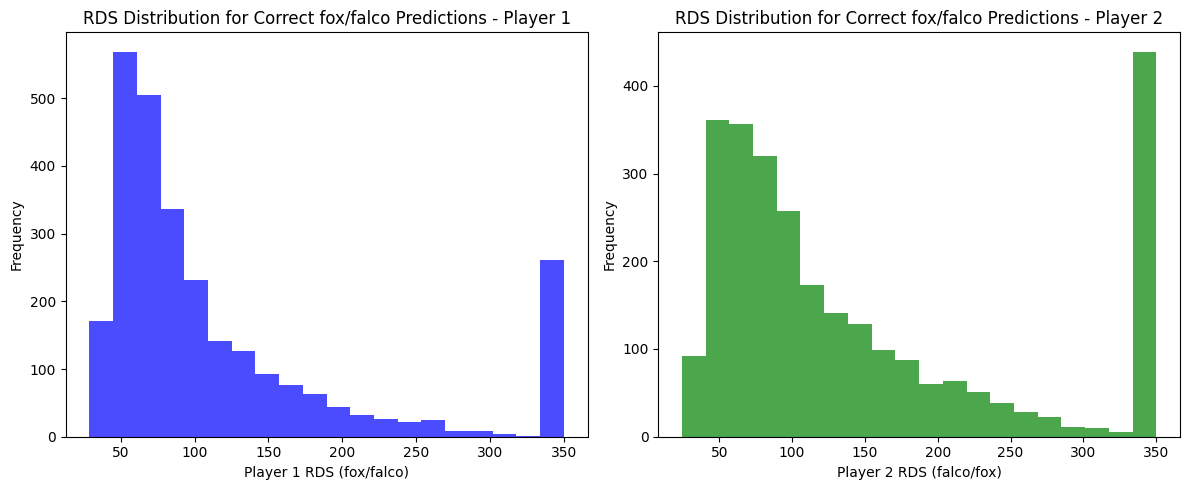

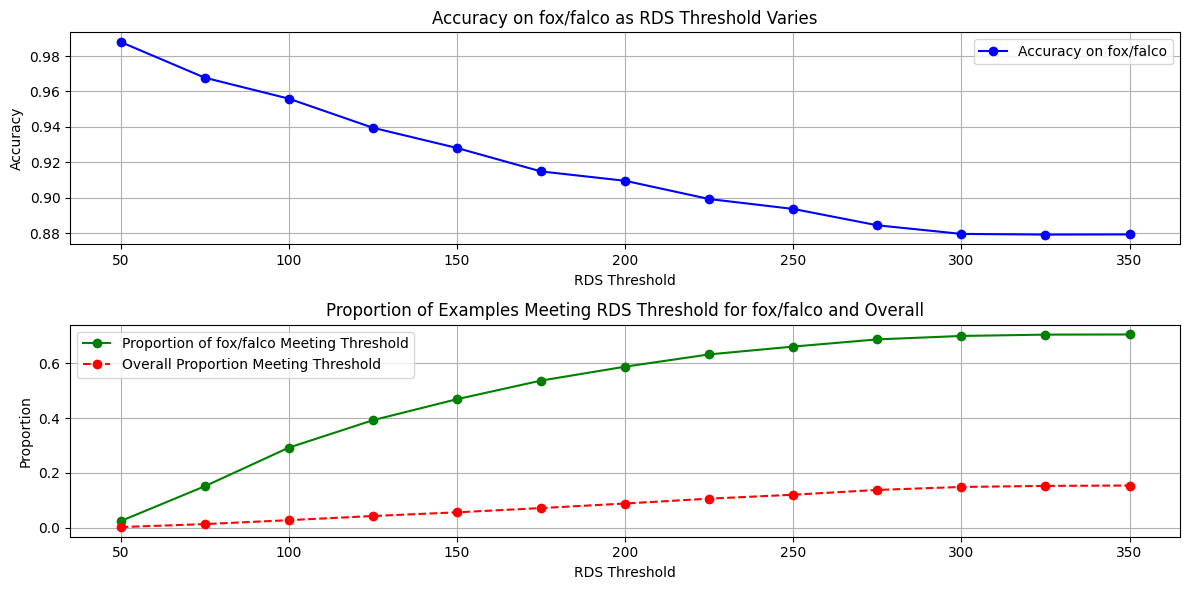

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Ensure `y_test` and `y_pred` are available in `df`
df['y_true'] = y_test
df['y_pred'] = y_pred
df['true_label'] = label_encoder.inverse_transform(y_test)
df['predicted_label'] = label_encoder.inverse_transform(y_pred)

# Add a column indicating whether the model's prediction is correct
df['correct_prediction'] = (df['y_true'] == df['y_pred']).astype(int)  # 1 for correct, 0 for incorrect

# Analyze `rds` values for correct predictions on the matchup 'fox/puff'
# Adjust the column names as needed for specific matchups
p1_char = 'fox'
p2_char = 'falco'
matchup_label = p1_char + '/' + p2_char
reverse_matchup_label = p2_char + '/' + p1_char

correct_fox_puff = df[(df['correct_prediction'] == 1) & (df['true_label'] == matchup_label)]
rds_player1_fox_puff = correct_fox_puff[f'p1_rds/{matchup_label}']
rds_player2_puff_fox = correct_fox_puff[f'p2_rds/{reverse_matchup_label}']

# Plot the distributions to visually inspect where correct predictions fall
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(rds_player1_fox_puff, bins=20, alpha=0.7, color='blue')
plt.xlabel(f'Player 1 RDS ({matchup_label})')
plt.ylabel('Frequency')
plt.title(f'RDS Distribution for Correct {matchup_label} Predictions - Player 1')

plt.subplot(1, 2, 2)
plt.hist(rds_player2_puff_fox, bins=20, alpha=0.7, color='green')
plt.xlabel(f'Player 2 RDS ({reverse_matchup_label})')
plt.ylabel('Frequency')
plt.title(f'RDS Distribution for Correct {matchup_label} Predictions - Player 2')

plt.tight_layout()
plt.show()

# Initialize lists to store results
thresholds = []
accuracies = []
matchup_proportions = []
overall_proportions = []

# Iterate over threshold values and store the results for each
for threshold in range(50, 375, 25):
    # Filter data where both players have an `rds` below the threshold for the matchup
    subset_df = df[
        (df[f'p1_rds/{matchup_label}'] < threshold) & 
        (df[f'p2_rds/{reverse_matchup_label}'] < threshold)
    ]
    
    # Filter subset for only examples with the label `matchup_label`
    label_subset_df = subset_df[subset_df['true_label'] == matchup_label]

    # Calculate accuracy on the filtered subset
    accuracy = accuracy_score(label_subset_df['y_true'], label_subset_df['y_pred']) if len(label_subset_df) > 0 else float('nan')
    
    # Calculate proportions
    total_matchup_label_count = (df['true_label'] == matchup_label).sum()
    proportion_meeting_threshold = len(label_subset_df) / total_matchup_label_count if total_matchup_label_count > 0 else 0
    overall_proportion = len(subset_df) / len(df)
    
    # Store results
    thresholds.append(threshold)
    accuracies.append(accuracy)
    matchup_proportions.append(proportion_meeting_threshold)
    overall_proportions.append(overall_proportion)

# Plot results
plt.figure(figsize=(12, 6))

# Plot Accuracy vs. Threshold
plt.subplot(2, 1, 1)
plt.plot(thresholds, accuracies, marker='o', color='b', label=f'Accuracy on {matchup_label}')
plt.xlabel('RDS Threshold')
plt.ylabel('Accuracy')
plt.title(f'Accuracy on {matchup_label} as RDS Threshold Varies')
plt.grid(True)
plt.legend()

# Plot Proportion of `matchup_label` Examples Meeting Threshold vs. Threshold
plt.subplot(2, 1, 2)
plt.plot(thresholds, matchup_proportions, marker='o', color='g', label=f'Proportion of {matchup_label} Meeting Threshold')
plt.plot(thresholds, overall_proportions, marker='o', color='r', linestyle='--', label='Overall Proportion Meeting Threshold')
plt.xlabel('RDS Threshold')
plt.ylabel('Proportion')
plt.title(f'Proportion of Examples Meeting RDS Threshold for {matchup_label} and Overall')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

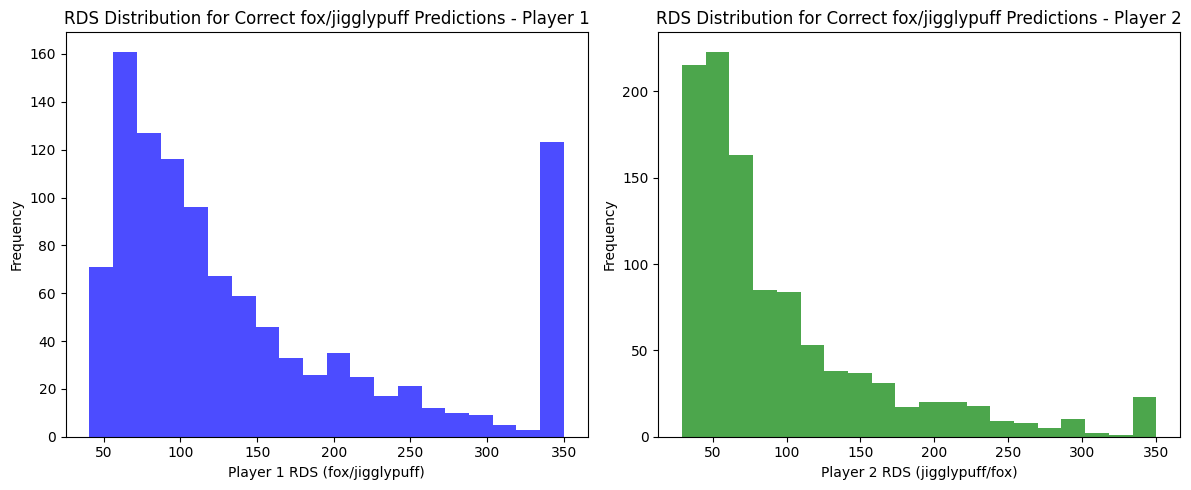

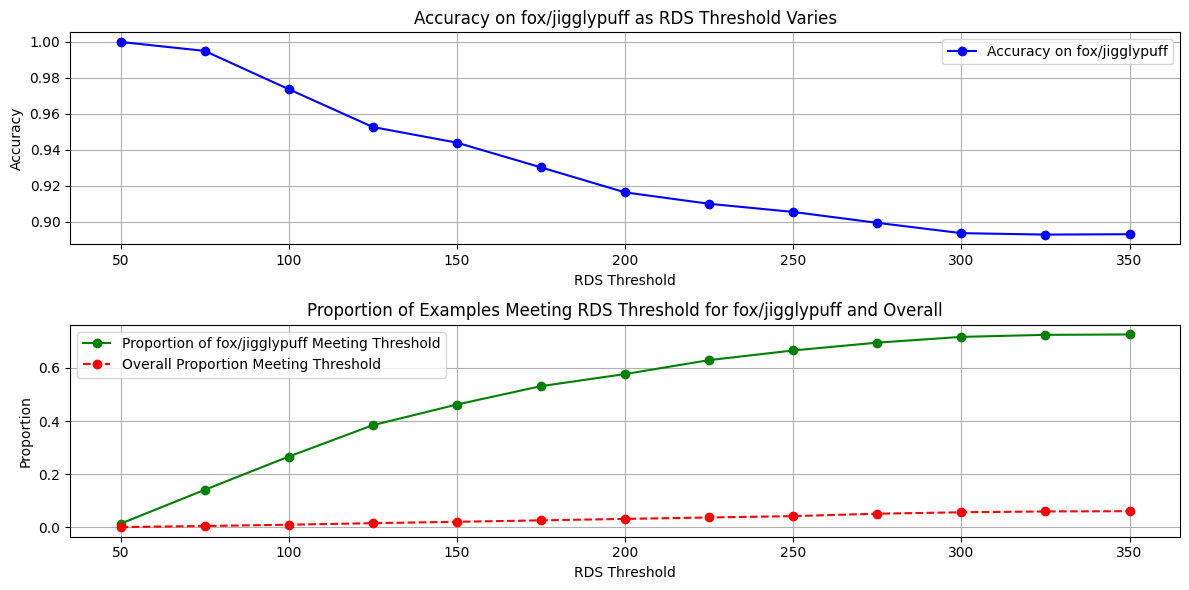

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Ensure `y_test` and `y_pred` are available in `df`
df['y_true'] = y_test
df['y_pred'] = y_pred
df['true_label'] = label_encoder.inverse_transform(y_test)
df['predicted_label'] = label_encoder.inverse_transform(y_pred)

# Add a column indicating whether the model's prediction is correct
df['correct_prediction'] = (df['y_true'] == df['y_pred']).astype(int)  # 1 for correct, 0 for incorrect

# Analyze `rds` values for correct predictions on the matchup 'fox/puff'
# Adjust the column names as needed for specific matchups
p1_char = 'fox'
p2_char = 'jigglypuff'
matchup_label = p1_char + '/' + p2_char
reverse_matchup_label = p2_char + '/' + p1_char

correct_fox_puff = df[(df['correct_prediction'] == 1) & (df['true_label'] == matchup_label)]
rds_player1_fox_puff = correct_fox_puff[f'p1_rds/{matchup_label}']
rds_player2_puff_fox = correct_fox_puff[f'p2_rds/{reverse_matchup_label}']

# Plot the distributions to visually inspect where correct predictions fall
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(rds_player1_fox_puff, bins=20, alpha=0.7, color='blue')
plt.xlabel(f'Player 1 RDS ({matchup_label})')
plt.ylabel('Frequency')
plt.title(f'RDS Distribution for Correct {matchup_label} Predictions - Player 1')

plt.subplot(1, 2, 2)
plt.hist(rds_player2_puff_fox, bins=20, alpha=0.7, color='green')
plt.xlabel(f'Player 2 RDS ({reverse_matchup_label})')
plt.ylabel('Frequency')
plt.title(f'RDS Distribution for Correct {matchup_label} Predictions - Player 2')

plt.tight_layout()
plt.show()

# Initialize lists to store results
thresholds = []
accuracies = []
matchup_proportions = []
overall_proportions = []

# Iterate over threshold values and store the results for each
for threshold in range(50, 375, 25):
    # Filter data where both players have an `rds` below the threshold for the matchup
    subset_df = df[
        (df[f'p1_rds/{matchup_label}'] < threshold) & 
        (df[f'p2_rds/{reverse_matchup_label}'] < threshold)
    ]
    
    # Filter subset for only examples with the label `matchup_label`
    label_subset_df = subset_df[subset_df['true_label'] == matchup_label]

    # Calculate accuracy on the filtered subset
    accuracy = accuracy_score(label_subset_df['y_true'], label_subset_df['y_pred']) if len(label_subset_df) > 0 else float('nan')
    
    # Calculate proportions
    total_matchup_label_count = (df['true_label'] == matchup_label).sum()
    proportion_meeting_threshold = len(label_subset_df) / total_matchup_label_count if total_matchup_label_count > 0 else 0
    overall_proportion = len(subset_df) / len(df)
    
    # Store results
    thresholds.append(threshold)
    accuracies.append(accuracy)
    matchup_proportions.append(proportion_meeting_threshold)
    overall_proportions.append(overall_proportion)

# Plot results
plt.figure(figsize=(12, 6))

# Plot Accuracy vs. Threshold
plt.subplot(2, 1, 1)
plt.plot(thresholds, accuracies, marker='o', color='b', label=f'Accuracy on {matchup_label}')
plt.xlabel('RDS Threshold')
plt.ylabel('Accuracy')
plt.title(f'Accuracy on {matchup_label} as RDS Threshold Varies')
plt.grid(True)
plt.legend()

# Plot Proportion of `matchup_label` Examples Meeting Threshold vs. Threshold
plt.subplot(2, 1, 2)
plt.plot(thresholds, matchup_proportions, marker='o', color='g', label=f'Proportion of {matchup_label} Meeting Threshold')
plt.plot(thresholds, overall_proportions, marker='o', color='r', linestyle='--', label='Overall Proportion Meeting Threshold')
plt.xlabel('RDS Threshold')
plt.ylabel('Proportion')
plt.title(f'Proportion of Examples Meeting RDS Threshold for {matchup_label} and Overall')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

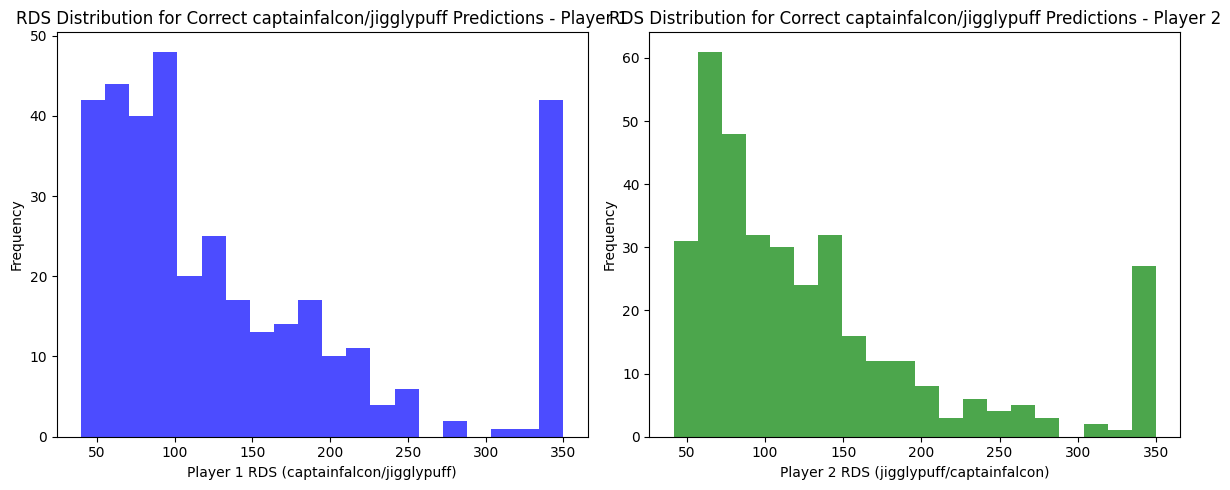

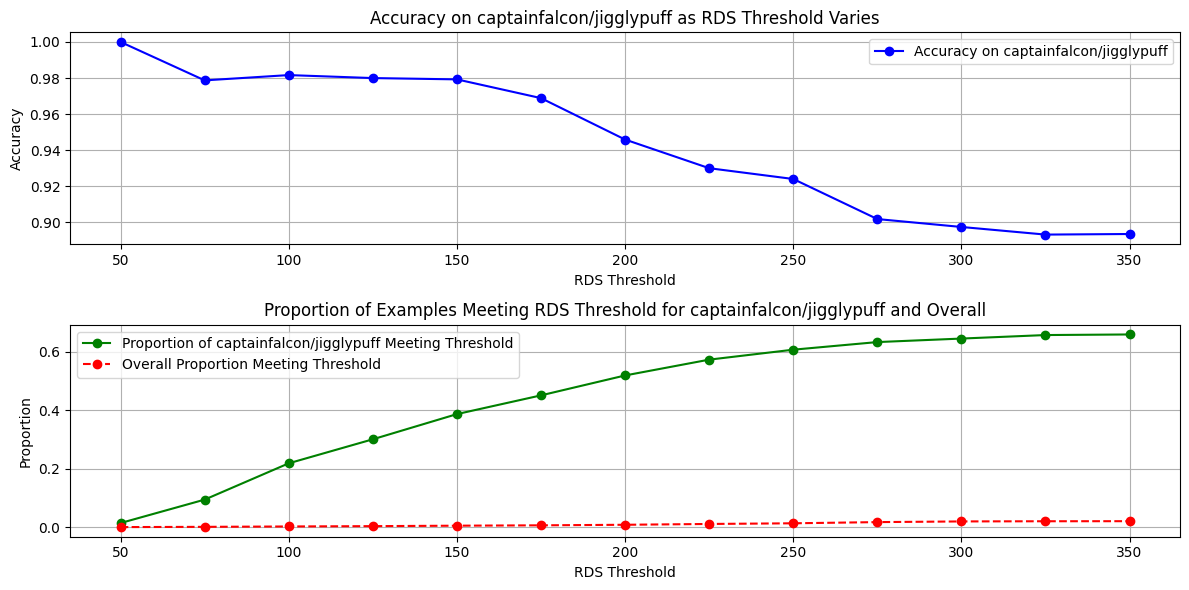

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Ensure `y_test` and `y_pred` are available in `df`
df['y_true'] = y_test
df['y_pred'] = y_pred
df['true_label'] = label_encoder.inverse_transform(y_test)
df['predicted_label'] = label_encoder.inverse_transform(y_pred)

# Add a column indicating whether the model's prediction is correct
df['correct_prediction'] = (df['y_true'] == df['y_pred']).astype(int)  # 1 for correct, 0 for incorrect

# Analyze `rds` values for correct predictions on the matchup 'fox/puff'
# Adjust the column names as needed for specific matchups
p1_char = 'captainfalcon'
p2_char = 'jigglypuff'
matchup_label = p1_char + '/' + p2_char
reverse_matchup_label = p2_char + '/' + p1_char

correct_fox_puff = df[(df['correct_prediction'] == 1) & (df['true_label'] == matchup_label)]
rds_player1_fox_puff = correct_fox_puff[f'p1_rds/{matchup_label}']
rds_player2_puff_fox = correct_fox_puff[f'p2_rds/{reverse_matchup_label}']

# Plot the distributions to visually inspect where correct predictions fall
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(rds_player1_fox_puff, bins=20, alpha=0.7, color='blue')
plt.xlabel(f'Player 1 RDS ({matchup_label})')
plt.ylabel('Frequency')
plt.title(f'RDS Distribution for Correct {matchup_label} Predictions - Player 1')

plt.subplot(1, 2, 2)
plt.hist(rds_player2_puff_fox, bins=20, alpha=0.7, color='green')
plt.xlabel(f'Player 2 RDS ({reverse_matchup_label})')
plt.ylabel('Frequency')
plt.title(f'RDS Distribution for Correct {matchup_label} Predictions - Player 2')

plt.tight_layout()
plt.show()

# Initialize lists to store results
thresholds = []
accuracies = []
matchup_proportions = []
overall_proportions = []

# Iterate over threshold values and store the results for each
for threshold in range(50, 375, 25):
    # Filter data where both players have an `rds` below the threshold for the matchup
    subset_df = df[
        (df[f'p1_rds/{matchup_label}'] < threshold) & 
        (df[f'p2_rds/{reverse_matchup_label}'] < threshold)
    ]
    
    # Filter subset for only examples with the label `matchup_label`
    label_subset_df = subset_df[subset_df['true_label'] == matchup_label]

    # Calculate accuracy on the filtered subset
    accuracy = accuracy_score(label_subset_df['y_true'], label_subset_df['y_pred']) if len(label_subset_df) > 0 else float('nan')
    
    # Calculate proportions
    total_matchup_label_count = (df['true_label'] == matchup_label).sum()
    proportion_meeting_threshold = len(label_subset_df) / total_matchup_label_count if total_matchup_label_count > 0 else 0
    overall_proportion = len(subset_df) / len(df)
    
    # Store results
    thresholds.append(threshold)
    accuracies.append(accuracy)
    matchup_proportions.append(proportion_meeting_threshold)
    overall_proportions.append(overall_proportion)

# Plot results
plt.figure(figsize=(12, 6))

# Plot Accuracy vs. Threshold
plt.subplot(2, 1, 1)
plt.plot(thresholds, accuracies, marker='o', color='b', label=f'Accuracy on {matchup_label}')
plt.xlabel('RDS Threshold')
plt.ylabel('Accuracy')
plt.title(f'Accuracy on {matchup_label} as RDS Threshold Varies')
plt.grid(True)
plt.legend()

# Plot Proportion of `matchup_label` Examples Meeting Threshold vs. Threshold
plt.subplot(2, 1, 2)
plt.plot(thresholds, matchup_proportions, marker='o', color='g', label=f'Proportion of {matchup_label} Meeting Threshold')
plt.plot(thresholds, overall_proportions, marker='o', color='r', linestyle='--', label='Overall Proportion Meeting Threshold')
plt.xlabel('RDS Threshold')
plt.ylabel('Proportion')
plt.title(f'Proportion of Examples Meeting RDS Threshold for {matchup_label} and Overall')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()